<a href="https://colab.research.google.com/github/pcpiscator/01T2021/blob/main/Furg_ECD_05_Machine_Learning_I_M%C3%A1quinas_de_vetores_de_suporte.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Especialização em Ciência de Dados - FURG
## Machine Learning I - Máquinas de vetores de suporte
### Prof. Marcelo Malheiros

Código adaptado de Aurélien Geron (licença Apache-2.0)

---

# Inicialização

Aqui importamos as bibliotecas fundamentais de Python para este _notebook_:

- NumPy: suporte a vetores, matrizes e operações de Álgebra Linear
- Matplotlib: biblioteca de visualização de dados
- Pandas: pacote estatístico e de manipulação de DataFrames
- Scikit-Learn: biblioteca com algoritmos de Machine Learning

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

# Classificação usando SVM

**Máquinas de vetores de suporte** (SVM) é uma técnica (ou algoritmo) clássico de Machine Learning.

É bastante versátil e eficiente para _datasets_ de tamanho pequeno ou médio. Além disso é útil para tarefas de classificação (que veremos a seguir) como de regressão (ao final deste _notebook_).

## Classificação linear

Aqui vamos usar um caso especializado de classificador SVM linear, chamado `LinearSVC`.

O objetivo é criar uma visualização da área de decisão em torno de algumas instâncias.

O conjunto de dados aqui é interno à biblioteca `Scikit-Learn`: é o mesmo _dataset_ sobre características de três espécies de flores, chamado IRIS.

In [4]:
# carregamento e preparação dos dados
from sklearn import datasets
iris = datasets.load_iris()

X_data = iris['data'][:, (2, 3)]  # comprimento da pétala, largura da pétala
y_data = (iris['target'] == 2).astype(np.float64)  # Iris virginica

In [5]:
# carregamento e preparação dos dados

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

X = pipeline.fit_transform(X_data)
y = y_data

In [9]:
# criação do modelo e treinamento

from sklearn.svm import LinearSVC

svm_clf = LinearSVC(C=1, loss='hinge', random_state=42)
svm_clf.fit(X, y);

In [12]:
# predição
svm_clf.predict([[5.5, 1.7]])

array([1.])

## Visualização da classificação linear

Experimente trocar o valor do parâmetro `C` e executar novamente as células até gerar a figura. Valores maiores de `C` fazem com que a área de decisão fique mais estreita.

Experimente com 0.1, 10, 100 e 1000, por exemplo. Note que para alguns valores a escolha da fronteira de decisão fica bem ruim.

In [14]:
svm_clf = LinearSVC(C=1, loss="hinge", random_state=42)

# note que aqui usamos um atalho: o modelo é colocado como a última parte do pipeline
scaler = StandardScaler()
scaled_svm_clf = Pipeline([
    ('scaler', scaler),
    ('linear_svc', svm_clf),
])

# a chamada a seguir primeiro transforma os dados (brutos) e então treina o modelo
scaled_svm_clf.fit(X_data, y_data);

# NOTA: é esperada a impressão de advertências abaixo para valores grandes de C

In [15]:
# conversão para parâmetros sem escalonamento
b = svm_clf.decision_function([-scaler.mean_ / scaler.scale_])
w = svm_clf.coef_[0] / scaler.scale_
svm_clf.intercept_ = np.array([b])
svm_clf.coef_ = np.array([w])

# busca dos vetores de suporte (LinearSVC não faz isso automaticamente)
t = y * 2 - 1
support_vectors_idx = (t * (X_data.dot(w) + b) < 1).ravel()
svm_clf.support_vectors_ = X_data[support_vectors_idx]

In [16]:
# função auxiliar

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

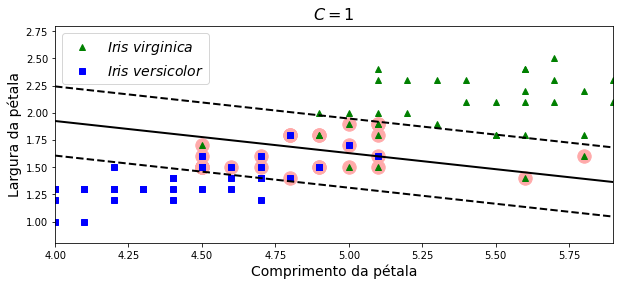

In [17]:
# plotagem

fig, axes = plt.subplots(figsize=(10,4))
plt.plot(X_data[:, 0][y_data==1], X_data[:, 1][y_data==1], "g^", label="$Iris\ virginica$")
plt.plot(X_data[:, 0][y_data==0], X_data[:, 1][y_data==0], "bs", label="$Iris\ versicolor$")
plot_svc_decision_boundary(svm_clf, 4, 5.9)
plt.xlabel("Comprimento da pétala", fontsize=14)
plt.ylabel("Largura da pétala", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])
plt.show()

## Classificação não linear - usando adição de features polinomiais

Aqui vamos usar um caso geral de classificador SVM, chamado `SVC`.

O objetivo é criar uma visualização da área de decisão em torno de algumas instâncias para um _dataset_ complexo.

O conjunto de dados aqui é sintético, chamado `moons` e gerado pela biblioteca `Scikit-Learn`.

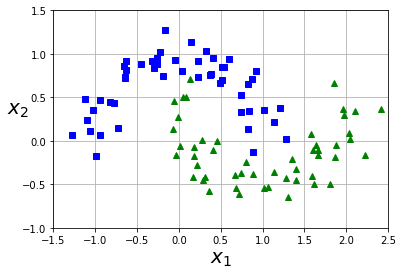

In [19]:
# carregamento e visualização dos dados

from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [21]:
# processamento (com adição de novas features de grau 3), criação do modelo e treinamento

from sklearn.preprocessing import PolynomialFeatures

# este pipeline já inclui o modelo no final
polynomial_svm_clf = Pipeline([
    ("poly_features", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf", LinearSVC(C=1, loss="hinge", random_state=42))
])

# transforma os dados (brutos) e treina o modelo
polynomial_svm_clf.fit(X, y);

# NOTA: é esperada a impressão de advertências abaixo para valores grandes de C

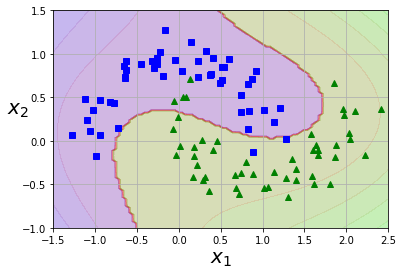

In [22]:
# plotagem

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

## Classificação não linear - usando kernel polinomial

Aqui é mostrado o mesmo classificador `SVC`, agora usando um esquema mais eficiente de cálculo usando um _kernel_ polinomial.

Dois modelos são treinados e mostrados lado a lado, com hiperparâmetros diferentes.

In [24]:
# estes pipelines já incluem o modelo no final

from sklearn.svm import SVC

poly_kernel_svm_clf1 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf1", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf2 = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf2", SVC(kernel="poly", degree=10, coef0=100, C=5))
])

# transforma os dados (brutos) e treina cada modelo
poly_kernel_svm_clf1.fit(X, y)
poly_kernel_svm_clf2.fit(X, y);

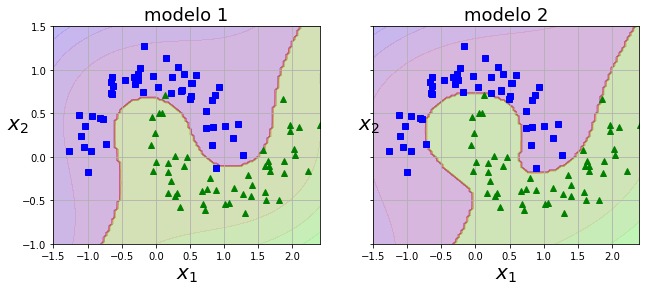

In [25]:
# plotagem das duas figuras

fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)
plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf1, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("modelo 1", fontsize=18)
plt.sca(axes[1])
plot_predictions(poly_kernel_svm_clf2, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title("modelo 2", fontsize=18)
plt.show()

## Classificação não linear - usando kernel gaussiano

Aqui é mostrado o mesmo classificador `SVC`, agora usando o esquema usando um _kernel_ gaussiano.

Quatro modelos são treinados com combinações de hiperparâmetros diferentes.

In [27]:
# hiperparâmetros para experimentar
gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

# estes pipelines já incluem o modelo no final
svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
    ])
    
    # transforma os dados (brutos) e treina cada modelo
    rbf_kernel_svm_clf.fit(X, y)
    
    # guarda modelo treinado para posterior visualização
    svm_clfs.append(rbf_kernel_svm_clf)

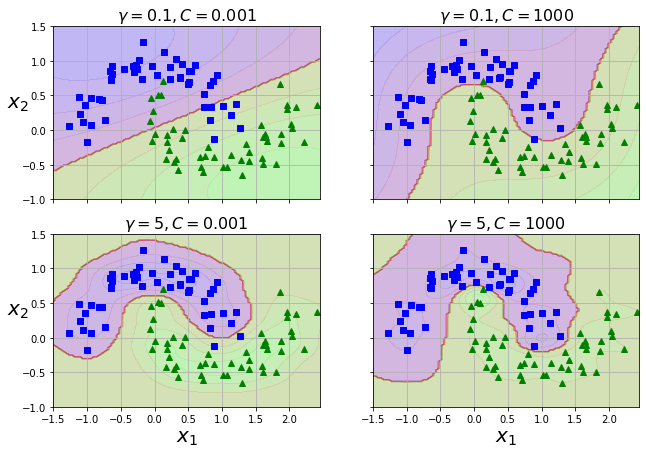

In [28]:
# plotagem das quatro figuras

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)
for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")
plt.show()

# Regressão usando SVM


## Regressão linear

Aqui um conjunto simples de valores aleatórios ao longo de uma linha é ajustado com o uso do algoritmo mais especializado `LinearSVR`.

In [29]:
# conjunto de dados

np.random.seed(42)
X = 2 * np.random.rand(50, 1)
y = (4 + 3 * X + np.random.randn(50, 1)).ravel()

In [30]:
# treinamento

from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y);

## Visualização da regressão linear

Aqui dois modelos são treinados, com diferença no hiperparâmetro `epsilon`. O resto do código é apenas para fazer a visualização dos dados junto com a área de ajuste (equivalente à área de decisão de um classificador).

In [31]:
# treinamento dos modelos
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

# informação sobre os vetores de suporte
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

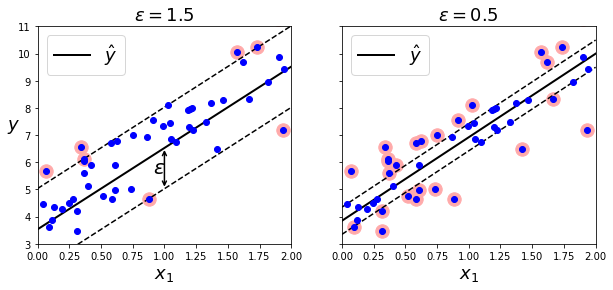

In [33]:
# plotagem

def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.annotate('', xy=(eps_x1, eps_y_pred), xycoords='data', xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
    textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5})
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

## Regressão não linear

Aqui um conjunto simples de valores aleatórios ao longo de uma curva quadrática é ajustado com o uso do algoritmo mais geral `SVR`.

In [35]:
# conjunto de dados

np.random.seed(42)
X = 2 * np.random.rand(100, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(100, 1)/10).ravel()

In [36]:
# treinamento

from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y);

## Visualização da regressão não linear

Aqui dois modelos são treinados, com diferença no hiperparâmetro `C`. O resto do código é apenas para fazer a visualização dos dados junto com a área de ajuste (equivalente à área de decisão de um classificador).

In [37]:
# treinamento dos modelos

from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y);

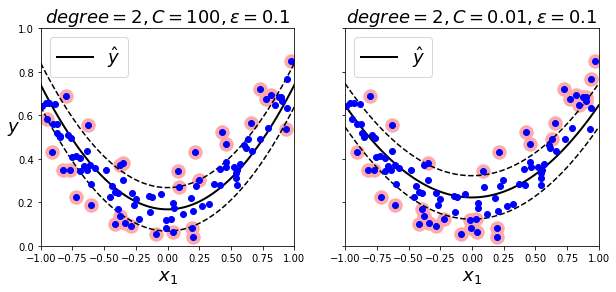

In [38]:
# plotagem

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon),
          fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon),
          fontsize=18)
plt.show()